Link to medium post: https://medium.com/@zhiwei_zhang/bitcoin-time-series-prediction-with-lstm-d3f49b1b4d00

In [1]:
import datetime
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import mean_squared_error
from math import sqrt

import keras
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout

Using TensorFlow backend.


In [27]:
btc_data = pd.read_csv("TataMotors.csv")

In [28]:
btc_data['Date_new'] = pd.to_datetime(btc_data.Date)

In [29]:
btc_data.head(10)

,Symbol,Series,Date,Prev Close,Open Price,High Price,Low Price,Last Price,Close Price,Average Price,Total Traded Quantity,Turnover,No. of Trades,Deliverable Qty,% Dly Qt to Traded Qty,Date_new
0,TATAMOTORS,EQ,11-Apr-14,430.80,428.90,437.80,422.20,423.00,423.60,429.01,6082343,2.609404e+09,73848,3070781,50.49,2014-04-11
1,TATAMOTORS,EQ,15-Apr-14,423.60,425.60,429.45,409.05,415.00,411.95,414.56,6865538,2.846208e+09,89910,3529239,51.41,2014-04-15
2,TATAMOTORS,EQ,16-Apr-14,411.95,409.50,418.95,409.35,412.70,411.15,413.40,3782508,1.563707e+09,71941,1595069,42.17,2014-04-16
3,TATAMOTORS,EQ,17-Apr-14,411.15,415.35,430.60,415.30,430.20,429.10,424.46,4577368,1.942890e+09,58447,1772729,38.73,2014-04-17
4,TATAMOTORS,EQ,21-Apr-14,429.10,424.90,434.55,424.15,432.00,432.10,430.02,2818637,1.212062e+09,32599,973720,34.55,2014-04-21
5,TATAMOTORS,EQ,22-Apr-14,432.10,430.90,434.70,426.60,428.35,428.80,430.35,2488045,1.070730e+09,38718,992845,39.90,2014-04-22
6,TATAMOTORS,EQ,23-Apr-14,428.80,430.30,433.70,422.30,425.85,425.05,426.82,5383562,2.297796e+09,71632,2951857,54.83,2014-04-23
7,TATAMOTORS,EQ,25-Apr-14,425.05,425.05,430.75,422.60,424.15,423.25,426.21,4118462,1.755311e+09,63783,2254092,54.73,2014-04-25
8,TATAMOTORS,EQ,28-Apr-14,423.25,423.10,423.10,415.00,416.55,416.45,418.21,3517997,1.471257e+09,38320,2067978,58.78,2014-04-28
9,TATAMOTORS,EQ,29-Apr-14,416.45,416.05,418.80,407.60,410.50,408.95,412.10,2379745,9.806843e+08,33496,1054331,44.30,2014-04-29


###  Load data by reading table from html

In [30]:
# only keeps date and close price
data = btc_data[['Date_new']+['Close Price']]
data = data.sort_values(by='Date_new')
data.head()

,Date_new,Close Price
0,2014-04-11,423.60
1,2014-04-15,411.95
2,2014-04-16,411.15
3,2014-04-17,429.10
4,2014-04-21,432.10


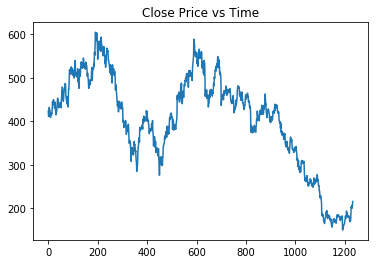

In [31]:
plt.plot(range(len(data['Close Price'])), data['Close Price'])
plt.title('Close Price vs Time')
plt.show()

In [32]:
# Normalize close price
from sklearn.preprocessing import MinMaxScaler
values = data['Close Price'].values.reshape(-1,1)
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_price = scaler.fit_transform(values)
scaled_price

array([[0.60130006],
       [0.5756308 ],
       [0.5738681 ],
       ...,
       [0.10983807],
       [0.12162611],
       [0.14399034]], dtype=float32)

In [33]:
# split data for training, testing
train_size = int(len(scaled_price) * 0.7)
test_size = len(scaled_price) - train_size

train, test = scaled_price[0:train_size,:], scaled_price[train_size:len(scaled_price),:]
print(len(train), len(test))

863 370


In [34]:
def create_input(data,lookback):
    inputs = []
    for i in range(len(data) - lookback):
        temp_set = data[i:(i + lookback),0].copy()
        inputs.append(temp_set)
    return np.array(inputs)

def create_output(data,lookback):
    output = []
    for i in range(len(data)-lookback):
        output.append(data[i + lookback, 0])
    return np.array(output)

# use lookback = 5
x_train = create_input(train,5)
x_test = create_input(test,5)

y_train = create_output(train,5)
y_test = create_output(test,5)

print('x_train shape', x_train.shape)
print('x_test shape', x_test.shape)

print('y_train shape', y_train.shape)
print('y_test shape', y_test.shape)


x_train shape (858, 5)
x_test shape (365, 5)
y_train shape (858,)
y_test shape (365,)


In [35]:
train

array([[0.60130006],
       [0.5756308 ],
       [0.5738681 ],
       [0.61341864],
       [0.62002873],
       [0.61275756],
       [0.6044949 ],
       [0.6005289 ],
       [0.58554596],
       [0.5690207 ],
       [0.5818002 ],
       [0.5818002 ],
       [0.5811392 ],
       [0.59149504],
       [0.5860968 ],
       [0.6000882 ],
       [0.6098932 ],
       [0.6488929 ],
       [0.6395286 ],
       [0.6426133 ],
       [0.63666415],
       [0.65913856],
       [0.6471302 ],
       [0.63710487],
       [0.6307151 ],
       [0.6171643 ],
       [0.618266  ],
       [0.64635897],
       [0.6299439 ],
       [0.6126474 ],
       [0.6028424 ],
       [0.5824612 ],
       [0.5950205 ],
       [0.5953509 ],
       [0.5978848 ],
       [0.6264185 ],
       [0.63545233],
       [0.65638435],
       [0.66696054],
       [0.65010476],
       [0.65847754],
       [0.63357943],
       [0.6172745 ],
       [0.63941836],
       [0.6223422 ],
       [0.63435066],
       [0.6331387 ],
       [0.627

In [36]:
x_train

array([[0.60130006, 0.5756308 , 0.5738681 , 0.61341864, 0.62002873],
       [0.5756308 , 0.5738681 , 0.61341864, 0.62002873, 0.61275756],
       [0.5738681 , 0.61341864, 0.62002873, 0.61275756, 0.6044949 ],
       ...,
       [0.58455443, 0.60118985, 0.60063905, 0.6040543 , 0.6057068 ],
       [0.60118985, 0.60063905, 0.6040543 , 0.6057068 , 0.60130006],
       [0.60063905, 0.6040543 , 0.6057068 , 0.60130006, 0.58345276]],
      dtype=float32)

In [37]:
print("x_input:",x_train[0:4])
print("y:",y_train[0:3])

x_input: [[0.60130006 0.5756308  0.5738681  0.61341864 0.62002873]
 [0.5756308  0.5738681  0.61341864 0.62002873 0.61275756]
 [0.5738681  0.61341864 0.62002873 0.61275756 0.6044949 ]
 [0.61341864 0.62002873 0.61275756 0.6044949  0.6005289 ]]
y: [0.61275756 0.6044949  0.6005289 ]


In [38]:
x_train = np.reshape(x_train,(x_train.shape[0],1,x_train.shape[1]))
x_test = np.reshape(x_test,(x_test.shape[0],1,x_test.shape[1]))
print('x_train shape', x_train.shape)
print('x_test shape', x_test.shape)

x_train shape (858, 1, 5)
x_test shape (365, 1, 5)


# Build Model

In [50]:
from keras.models import Sequential
from keras.layers import Dense,LSTM,Dropout, Flatten,Conv2D, MaxPooling2D, Activation
from keras.layers.normalization import BatchNormalization
from keras import optimizers
import keras

model_1 = Sequential()
model_1.add(LSTM(300, input_shape=(1,x_train.shape[2])))
model_1.add(Dense(1))
model_1.compile(loss='mae', optimizer='adam')
model_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 300)               367200    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 301       
Total params: 367,501
Trainable params: 367,501
Non-trainable params: 0
_________________________________________________________________


In [51]:
history = model_1.fit(x_train, y_train, epochs=300, batch_size=128, 
                    validation_data=(x_test, y_test), verbose=1, shuffle=False)

Train on 858 samples, validate on 365 samples
Epoch 1/300
858/858 [==============================] - 2s 2ms/step - loss: 0.5820 - val_loss: 0.1846
Epoch 2/300
858/858 [==============================] - 0s 270us/step - loss: 0.3880 - val_loss: 0.1029
Epoch 3/300
858/858 [==============================] - 0s 354us/step - loss: 0.1675 - val_loss: 0.0758
Epoch 4/300
858/858 [==============================] - 0s 293us/step - loss: 0.0786 - val_loss: 0.1474
Epoch 5/300
858/858 [==============================] - 0s 256us/step - loss: 0.0851 - val_loss: 0.0879
Epoch 6/300
858/858 [==============================] - 0s 263us/step - loss: 0.0439 - val_loss: 0.0657
Epoch 7/300
858/858 [==============================] - 0s 298us/step - loss: 0.0452 - val_loss: 0.0863
Epoch 8/300
858/858 [==============================] - 0s 326us/step - loss: 0.0375 - val_loss: 0.0876
Epoch 9/300
858/858 [==============================] - 0s 314us/step - loss: 0.0316 - val_loss: 0.0697
Epoch 10/300
858/858 [=======

858/858 [==============================] - 0s 311us/step - loss: 0.0207 - val_loss: 0.0264
Epoch 80/300
858/858 [==============================] - 0s 282us/step - loss: 0.0207 - val_loss: 0.0265
Epoch 81/300
858/858 [==============================] - 0s 294us/step - loss: 0.0207 - val_loss: 0.0263
Epoch 82/300
858/858 [==============================] - 0s 359us/step - loss: 0.0206 - val_loss: 0.0264
Epoch 83/300
858/858 [==============================] - 0s 321us/step - loss: 0.0206 - val_loss: 0.0265
Epoch 84/300
858/858 [==============================] - 0s 301us/step - loss: 0.0206 - val_loss: 0.0263
Epoch 85/300
858/858 [==============================] - 0s 285us/step - loss: 0.0205 - val_loss: 0.0262
Epoch 86/300
858/858 [==============================] - 0s 324us/step - loss: 0.0204 - val_loss: 0.0262
Epoch 87/300
858/858 [==============================] - 0s 366us/step - loss: 0.0204 - val_loss: 0.0262
Epoch 88/300
858/858 [==============================] - 0s 310us/step - loss:

858/858 [==============================] - 0s 374us/step - loss: 0.0185 - val_loss: 0.0220
Epoch 158/300
858/858 [==============================] - 0s 391us/step - loss: 0.0185 - val_loss: 0.0220
Epoch 159/300
858/858 [==============================] - 0s 321us/step - loss: 0.0185 - val_loss: 0.0219
Epoch 160/300
858/858 [==============================] - 0s 394us/step - loss: 0.0185 - val_loss: 0.0220
Epoch 161/300
858/858 [==============================] - 0s 296us/step - loss: 0.0185 - val_loss: 0.0220
Epoch 162/300
858/858 [==============================] - 0s 473us/step - loss: 0.0185 - val_loss: 0.0221
Epoch 163/300
858/858 [==============================] - 0s 328us/step - loss: 0.0186 - val_loss: 0.0223
Epoch 164/300
858/858 [==============================] - 0s 310us/step - loss: 0.0187 - val_loss: 0.0222
Epoch 165/300
858/858 [==============================] - 0s 331us/step - loss: 0.0187 - val_loss: 0.0221
Epoch 166/300
858/858 [==============================] - 0s 382us/ste

Epoch 235/300
858/858 [==============================] - 0s 346us/step - loss: 0.0179 - val_loss: 0.0201
Epoch 236/300
858/858 [==============================] - 0s 348us/step - loss: 0.0178 - val_loss: 0.0197
Epoch 237/300
858/858 [==============================] - 0s 294us/step - loss: 0.0176 - val_loss: 0.0197
Epoch 238/300
858/858 [==============================] - 0s 272us/step - loss: 0.0177 - val_loss: 0.0197
Epoch 239/300
858/858 [==============================] - 0s 292us/step - loss: 0.0177 - val_loss: 0.0194
Epoch 240/300
858/858 [==============================] - 0s 280us/step - loss: 0.0176 - val_loss: 0.0194
Epoch 241/300
858/858 [==============================] - 0s 333us/step - loss: 0.0177 - val_loss: 0.0195
Epoch 242/300
858/858 [==============================] - 0s 281us/step - loss: 0.0177 - val_loss: 0.0196
Epoch 243/300
858/858 [==============================] - 0s 390us/step - loss: 0.0178 - val_loss: 0.0196
Epoch 244/300
858/858 [==============================] 

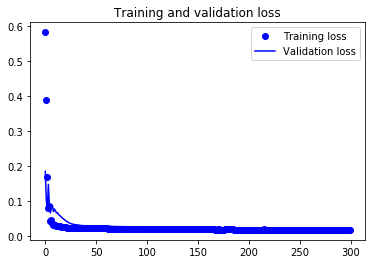

In [52]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

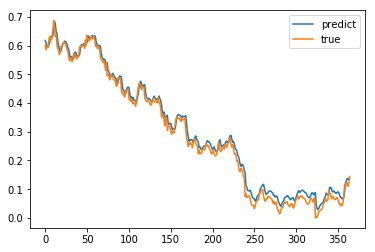

In [53]:
yhat = model_1.predict(x_test)
plt.plot(yhat, label='predict')
plt.plot(y_test, label='true')
plt.legend()
plt.show()

In [54]:
yhat_inverse = scaler.inverse_transform(yhat.reshape(-1, 1))
testY_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))
rmse = sqrt(mean_squared_error(testY_inverse, yhat_inverse))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 9.702


### Add a dropout layer

In [55]:
from keras import backend as K
K.clear_session()

In [56]:
model_2 = Sequential()
model_2.add(LSTM(300, input_shape=(1, x_train.shape[2])))
model_2.add(Dropout(0.2))
model_2.add(Dense(1))
model_2.compile(loss='mae', optimizer='adam')
model_2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 300)               367200    
_________________________________________________________________
dropout_1 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 301       
Total params: 367,501
Trainable params: 367,501
Non-trainable params: 0
_________________________________________________________________


In [57]:
model_2.compile(loss='mae', optimizer='adam')
history = model_2.fit(x_train, y_train, epochs=300, batch_size=128, 
                    validation_data=(x_test, y_test), verbose=1, shuffle=False)

Train on 858 samples, validate on 365 samples
Epoch 1/300
858/858 [==============================] - 2s 2ms/step - loss: 0.5541 - val_loss: 0.1721
Epoch 2/300
858/858 [==============================] - 0s 258us/step - loss: 0.3594 - val_loss: 0.0924
Epoch 3/300
858/858 [==============================] - 0s 281us/step - loss: 0.1391 - val_loss: 0.0860
Epoch 4/300
858/858 [==============================] - 0s 247us/step - loss: 0.0788 - val_loss: 0.1354
Epoch 5/300
858/858 [==============================] - 0s 279us/step - loss: 0.0654 - val_loss: 0.0755
Epoch 6/300
858/858 [==============================] - 0s 338us/step - loss: 0.0490 - val_loss: 0.0661
Epoch 7/300
858/858 [==============================] - 0s 296us/step - loss: 0.0444 - val_loss: 0.0880
Epoch 8/300
858/858 [==============================] - 0s 267us/step - loss: 0.0419 - val_loss: 0.0803
Epoch 9/300
858/858 [==============================] - 0s 268us/step - loss: 0.0378 - val_loss: 0.0671
Epoch 10/300
858/858 [=======

858/858 [==============================] - 0s 379us/step - loss: 0.0262 - val_loss: 0.0254
Epoch 80/300
858/858 [==============================] - 0s 263us/step - loss: 0.0267 - val_loss: 0.0267
Epoch 81/300
858/858 [==============================] - 0s 309us/step - loss: 0.0266 - val_loss: 0.0249
Epoch 82/300
858/858 [==============================] - 0s 308us/step - loss: 0.0276 - val_loss: 0.0251
Epoch 83/300
858/858 [==============================] - 0s 253us/step - loss: 0.0256 - val_loss: 0.0282
Epoch 84/300
858/858 [==============================] - 0s 353us/step - loss: 0.0273 - val_loss: 0.0253
Epoch 85/300
858/858 [==============================] - 0s 330us/step - loss: 0.0269 - val_loss: 0.0241
Epoch 86/300
858/858 [==============================] - 0s 280us/step - loss: 0.0268 - val_loss: 0.0272
Epoch 87/300
858/858 [==============================] - 0s 334us/step - loss: 0.0260 - val_loss: 0.0266
Epoch 88/300
858/858 [==============================] - 0s 413us/step - loss:

Epoch 157/300
858/858 [==============================] - 0s 282us/step - loss: 0.0254 - val_loss: 0.0239
Epoch 158/300
858/858 [==============================] - 0s 240us/step - loss: 0.0236 - val_loss: 0.0236
Epoch 159/300
858/858 [==============================] - 0s 309us/step - loss: 0.0234 - val_loss: 0.0243
Epoch 160/300
858/858 [==============================] - 0s 288us/step - loss: 0.0233 - val_loss: 0.0226
Epoch 161/300
858/858 [==============================] - 0s 308us/step - loss: 0.0236 - val_loss: 0.0214
Epoch 162/300
858/858 [==============================] - ETA: 0s - loss: 0.024 - 0s 268us/step - loss: 0.0236 - val_loss: 0.0227
Epoch 163/300
858/858 [==============================] - 0s 275us/step - loss: 0.0232 - val_loss: 0.0244
Epoch 164/300
858/858 [==============================] - 0s 291us/step - loss: 0.0244 - val_loss: 0.0245
Epoch 165/300
858/858 [==============================] - 0s 335us/step - loss: 0.0244 - val_loss: 0.0238
Epoch 166/300
858/858 [========

Epoch 235/300
858/858 [==============================] - 0s 423us/step - loss: 0.0226 - val_loss: 0.0231
Epoch 236/300
858/858 [==============================] - 0s 311us/step - loss: 0.0233 - val_loss: 0.0207
Epoch 237/300
858/858 [==============================] - 0s 296us/step - loss: 0.0219 - val_loss: 0.0213
Epoch 238/300
858/858 [==============================] - 0s 287us/step - loss: 0.0216 - val_loss: 0.0209
Epoch 239/300
858/858 [==============================] - 0s 325us/step - loss: 0.0232 - val_loss: 0.0217
Epoch 240/300
858/858 [==============================] - 0s 302us/step - loss: 0.0219 - val_loss: 0.0202
Epoch 241/300
858/858 [==============================] - 0s 312us/step - loss: 0.0224 - val_loss: 0.0198
Epoch 242/300
858/858 [==============================] - 0s 296us/step - loss: 0.0221 - val_loss: 0.0218
Epoch 243/300
858/858 [==============================] - 0s 346us/step - loss: 0.0232 - val_loss: 0.0252
Epoch 244/300
858/858 [==============================] 

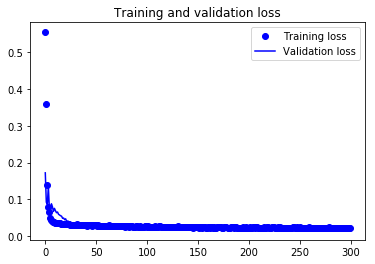

In [58]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

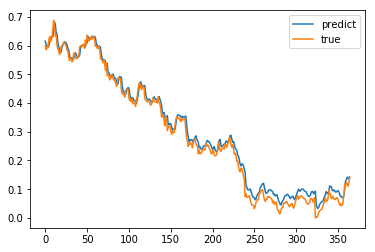

In [59]:
yhat = model_2.predict(x_test)
plt.plot(yhat, label='predict')
plt.plot(y_test, label='true')
plt.legend()
plt.show()

In [60]:
yhat_inverse = scaler.inverse_transform(yhat.reshape(-1, 1))
testY_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))
rmse = sqrt(mean_squared_error(testY_inverse, yhat_inverse))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 10.254
